# <center>UrbanSound8K - Model Training</center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries-Import" data-toc-modified-id="Libraries-Import-1">Libraries Import</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2">Parameters</a></span></li><li><span><a href="#Import-of-the-Metadata-File" data-toc-modified-id="Import-of-the-Metadata-File-3">Import of the Metadata File</a></span></li><li><span><a href="#Creation-of-the-Dataset-Class" data-toc-modified-id="Creation-of-the-Dataset-Class-4">Creation of the Dataset Class</a></span></li><li><span><a href="#Instantiation-of-the-Dataset" data-toc-modified-id="Instantiation-of-the-Dataset-5">Instantiation of the Dataset</a></span></li><li><span><a href="#Dataset-Exploration" data-toc-modified-id="Dataset-Exploration-6">Dataset Exploration</a></span><ul class="toc-item"><li><span><a href="#Classes-Counts" data-toc-modified-id="Classes-Counts-6.1">Classes Counts</a></span></li><li><span><a href="#Duration-of-Events" data-toc-modified-id="Duration-of-Events-6.2">Duration of Events</a></span></li><li><span><a href="#Salience" data-toc-modified-id="Salience-6.3">Salience</a></span><ul class="toc-item"><li><span><a href="#Global" data-toc-modified-id="Global-6.3.1">Global</a></span></li><li><span><a href="#Per-Class" data-toc-modified-id="Per-Class-6.3.2">Per Class</a></span></li></ul></li><li><span><a href="#Folds-Distribution" data-toc-modified-id="Folds-Distribution-6.4">Folds Distribution</a></span></li><li><span><a href="#Visualition-of-an-Event" data-toc-modified-id="Visualition-of-an-Event-6.5">Visualition of an Event</a></span></li></ul></li><li><span><a href="#Creation-of-the-Model" data-toc-modified-id="Creation-of-the-Model-7">Creation of the Model</a></span></li><li><span><a href="#Creation-of-the-Pipeline" data-toc-modified-id="Creation-of-the-Pipeline-8">Creation of the Pipeline</a></span></li><li><span><a href="#Model-Training-and-Validation" data-toc-modified-id="Model-Training-and-Validation-9">Model Training and Validation</a></span></li></ul></div>

## Libraries Import

In [1]:
import os
import math
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torchmetrics import Accuracy, Precision, Recall, F1, ConfusionMatrix
import torchaudio
import torchaudio.transforms as transforms
import torchvision
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Parameters

In [2]:
########################################################################
dataset_path = "dataset"
########################################################################
# Choose the device to operate on
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Used device: {device}")
########################################################################
# Transforms parameters
target_sample_rate = 22050
target_length = 4
n_samples = target_length * target_sample_rate
n_fft = 512
n_mels = 64

transforms_params = {
    "target_sample_rate": target_sample_rate,
    "target_length": target_length,
    "n_samples": n_samples,
    "n_fft": n_fft,
    "n_mels": n_mels
}

Used device: cuda


## Import of the Metadata File

In [3]:
metadata = pd.read_csv("dataset/UrbanSound8K.csv")
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


## Filtering on Classes (Optional)

In [4]:
classes_filter = ["dog_bark", "siren"]

metadata = metadata[metadata["class"].isin(classes_filter)].reset_index(drop=True)
metadata
for id, classe in enumerate(classes_filter):
    metadata.loc[metadata["class"]==classe, "classID"] = id
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,0,dog_bark
1,100652-3-0-0.wav,100652,0.000000,4.000000,1,2,0,dog_bark
2,100652-3-0-1.wav,100652,0.500000,4.500000,1,2,0,dog_bark
3,100652-3-0-2.wav,100652,1.000000,5.000000,1,2,0,dog_bark
4,100652-3-0-3.wav,100652,1.500000,5.500000,1,2,0,dog_bark
...,...,...,...,...,...,...,...,...
1924,97392-3-0-0.wav,97392,0.000000,2.773946,1,6,0,dog_bark
1925,97756-3-0-0.wav,97756,0.141727,1.290466,1,10,0,dog_bark
1926,98525-8-0-0.wav,98525,0.000000,4.000000,1,7,1,siren
1927,98536-8-0-0.wav,98536,0.000000,1.358367,1,8,1,siren


## Folds Distribution

In [5]:
# Group by fold and label and pivot
folds_vc = metadata.groupby(["fold", "class"], dropna=False, as_index=False)["class"].size()
folds_vc.pivot(index="class", columns="fold", values="size")

fold,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,
dog_bark,100,100,100,100,100,100,100,100,100,100
siren,86,91,119,166,71,74,77,80,82,83


## Creation of the Dataset Class

In [6]:
class UrbanSound8K(Dataset):
    
    def __init__(self, metadata, dataset_path, transforms_params, device):
        self.device = device
        self.metadata = metadata
        self.dataset_path = dataset_path
        self.n_folds = max(metadata["fold"])
        self.n_classes = len(metadata["class"].unique())
        self.classes_map = pd.Series(metadata["class"].values,index=metadata["classID"]).sort_index().to_dict()
        self.target_sample_rate = transforms_params["target_sample_rate"]
        self.target_length = transforms_params["target_length"]
        self.n_samples = transforms_params["n_samples"]
        self.n_fft = transforms_params["n_fft"]
        self.n_mels = transforms_params["n_mels"]
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        audio_name = self._get_event_audio_name(index)
        class_id = torch.tensor(self._get_event_class_id(index), dtype=torch.long)
        signal, sr = self._get_event_signal(index)
        signal = signal.to(self.device)
        signal = self._mix_down_if_necessary(signal)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        #spectrogram = self._spectrogram_transform(signal)
        #spectrogram_db = self._db_transform(spectrogram)
        mel_spectrogram = self._mel_spectrogram_transform(signal)
        mel_spectrogram_db = self._db_transform(mel_spectrogram)
        return mel_spectrogram_db, class_id, audio_name
    
    def _get_event_class_id(self, index):
        return self.metadata.iloc[index]["classID"]
    
    def _get_event_audio_name(self, index):
        return self.metadata.iloc[index]["slice_file_name"]
    
    def _get_event_signal(self, index):
        event_fold = f"fold{self.metadata.iloc[index]['fold']}"
        event_filename = self.metadata.iloc[index]["slice_file_name"]
        audio_path = os.path.join(self.dataset_path, event_fold, event_filename)
        signal, sr = torchaudio.load(audio_path)
        return signal, sr
    
    def _mix_down_if_necessary(self, signal):
        # If signal has multiple channels, mix down to mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resample_transform = resample_transform.to(self.device)
            signal = resample_transform(signal)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.n_samples:
            signal = signal[:, :self.n_samples]
        return signal
        
    def _right_pad_if_necessary(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.n_samples:
            num_missing_samples = self.n_samples - signal_length
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _spectrogram_transform(self, signal):
        spectrogram_transform = transforms.Spectrogram(
                                                        n_fft = self.n_fft,
                                                        win_length = self.n_fft,
                                                        hop_length = self.n_fft // 2,
                                                        pad = 0,
                                                        window_fn = torch.hann_window,
                                                        power = 2,
                                                        normalized = True,
                                                        wkwargs = None,
                                                        center = False,
                                                        pad_mode = "reflect",
                                                        onesided = True,
                                                        return_complex = False
                                                        )  
        spectrogram_transform = spectrogram_transform.to(self.device)
        spectrogram = spectrogram_transform(signal)
        return spectrogram
    
    def _mel_spectrogram_transform(self, signal):
        mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
                                                        sample_rate = self.target_sample_rate,
                                                        n_fft = self.n_fft,
                                                        n_mels = self.n_mels,
                                                        window_fn = torch.hann_window,
                                                        power = 2,
                                                        normalized = True,
                                                        wkwargs = None,
                                                        center = True,
                                                        pad_mode = "reflect",
                                                        onesided = True,
                                                        norm = None,
                                                        mel_scale = "htk"
                                                        )
        mel_spectrogram_transform = mel_spectrogram_transform.to(self.device)
        mel_spectrogram = mel_spectrogram_transform(signal)
        return mel_spectrogram
    
    def _db_transform(self, spectrogram):
        db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")
        db_transform = db_transform.to(self.device)
        spectrogram_db = db_transform(spectrogram)
        return spectrogram_db
        

## Instantiation of the Dataset

In [7]:
# Instantiate a dataset object
dataset = UrbanSound8K(
    metadata=metadata,
    dataset_path=dataset_path, 
    transforms_params=transforms_params,
    device=device
)

## Visualition of an Event

,slice_file_name,fsID,start,end,salience,fold,classID,class
335,128470-3-0-0.wav,128470,1.711988,5.711988,1,10,0,dog_bark


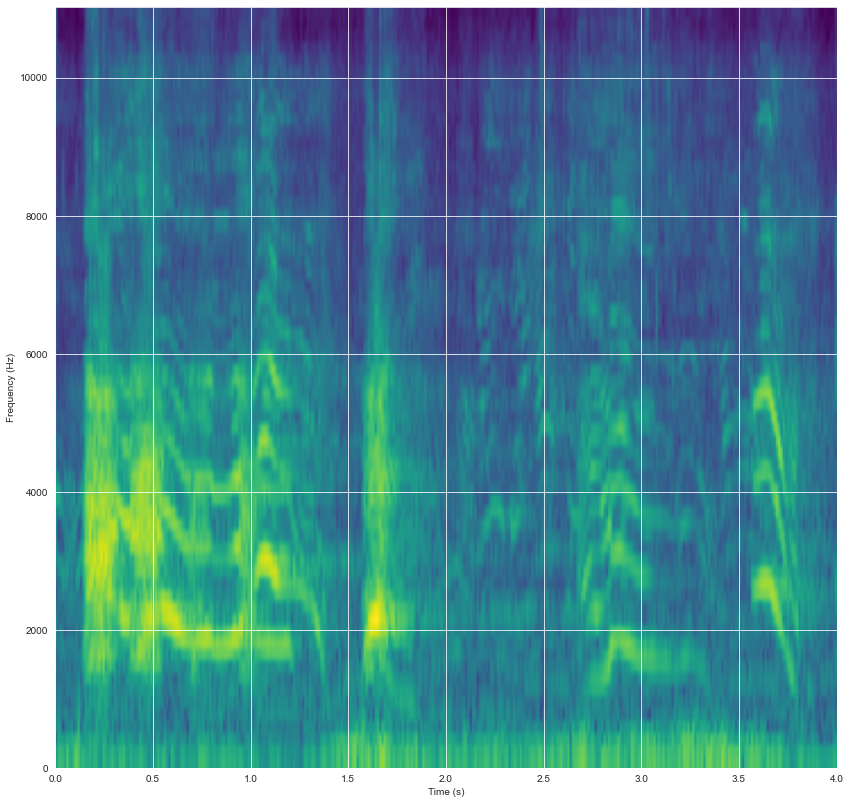

In [8]:
# Input annotations filtering critera
label = "dog_bark"
salience = 1 

# Filter annotations based on criteria
filtered_metadata = dataset.metadata.loc[
    (metadata["class"]==label)
    & (metadata["salience"]==salience)
    ]

# Randomly select the desired number of events from the filtered annotations
selected_event = filtered_metadata.sample(n=1) 
display(selected_event)
selected_event_index = selected_event.index.item()

features, label, _ = dataset[selected_event_index]

features = features.cpu()
features = torch.squeeze(features)

plt.figure(figsize=(14,14))
plt.imshow(features, extent=[0, target_length, 0, target_sample_rate/2], origin="lower", aspect="auto", cmap="viridis")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Build the audio path
selected_event_fold = f"fold{selected_event.iloc[0]['fold']}"
selected_event_filename = selected_event.iloc[0]["slice_file_name"]
selected_audio_path = os.path.join(dataset_path, selected_event_fold, selected_event_filename)
display(IPython.display.Audio(filename=selected_audio_path))

## Creation of the Pipeline

In [9]:
class Pipeline(pl.LightningModule):
    def __init__(self, out_dim, classes_map, lr):
        super().__init__()
        
        # Save hyperparameters to the checkpoint
        self.save_hyperparameters()        

        # Definition of the model
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.3)
            )
        self.flatten = nn.Sequential(nn.Flatten()) 
        self.dense = nn.Sequential(
            nn.Linear(128 * 16 * 86, 512),
            nn.Linear(512, 256),
            nn.Linear(256, out_dim)
            )
        
        # Instantiation of the metrics
        self.accuracy = Accuracy(num_classes=len(classes_map), average="weighted")
        self.recall = Recall(num_classes=len(classes_map), average="weighted")
        self.f1_score = F1(num_classes=len(classes_map), average="weighted")
        self.confmat = ConfusionMatrix(num_classes=len(classes_map))           
        
        # Instantiation of the classes map
        self.classes_map = classes_map
        
        # Instantiation of the number of classes
        self.n_classes = len(classes_map)
        
        # Instatiation of the learning rate
        self.lr = lr
        
        
    def configure_optimizers(self):
        
        optimizer = Adam(self.parameters(), lr=self.lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
            
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                        "scheduler": scheduler,
                        "monitor": "validation_loss",
                        "frequency": 1
                        }
                }
    
    def forward(self, x):

        x = self.conv_block(x)
        x = self.flatten(x)
        logits = self.dense(x)
        
        return logits 
    
        
    def training_step(self, train_batch, batch_idx): 
        
        # Unpack the training batch
        inputs, targets, _ = train_batch
        # Pass the inputs to the model to get the logits
        logits = self(inputs)
        # Compute the loss
        loss = F.cross_entropy(logits, targets)
        # Get the probabilities for each class by applying softmax
        probs = F.softmax(logits, dim=1)
        # Get the prediction for each batch sample
        _, preds = torch.max(probs, 1)
        # Compute the accuracy
        accuracy = self.accuracy(logits, targets)
        # Log the loss
        self.log("training_loss", loss, on_step=True, on_epoch=True)
        
        return {"inputs":inputs, "targets":targets, "predictions":preds, "loss":loss}
    
    
    def training_epoch_end(self, outputs):

        # Log weights and biases for all layers of the model
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params,self.current_epoch)
        
        # Only after the first training epoch, log one of the training inputs as a figure and log the model graph
        if self.current_epoch == 0:
            input_sample = outputs[0]["inputs"][0]
            input_sample_target = outputs[0]["targets"][0].item()
            input_sample_class = self.classes_map[input_sample_target]
            fig = plt.figure(figsize=(20,20))
            ax = fig.add_subplot(111)
            ax.imshow(torch.squeeze(input_sample).cpu(), cmap="viridis", origin="lower", aspect="auto")
            ax.set_title(f"Class: {input_sample_class}")
            ax.set_xlabel("Time Frames")
            ax.set_ylabel("Mel Bands")
            self.logger.experiment.add_figure(f"Training sample input", fig)
            input_sample = torch.unsqueeze(input_sample, 3)
            input_sample = torch.permute(input_sample, (0,3,1,2))
            self.logger.experiment.add_graph(self, input_sample)

            
    def validation_step(self, validation_batch, batch_idx):
        
        # Unpack the validation batch
        inputs, targets, audios_name = validation_batch
        # Load 
        self.logger.experiment.add_image("Validation image", inputs[0], 0)
        # Pass the inputs to the model to get the logits
        logits = self(inputs)
        # Compute the loss and log it for early stopping monitoring
        loss = F.cross_entropy(logits, targets)
        # Get the probabilities for each class by applying softmax
        probs = F.softmax(logits, dim=1)
        # Get the prediction for each batch sample
        _, preds = torch.max(probs, 1)
        # Compute the accuracy for this batch
        accuracy = self.accuracy(preds, targets)
        # Log the loss and the accuracy
        self.log("validation_loss", loss, on_step=True, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_step=True, on_epoch=True)
        
        return {"inputs":inputs, "targets":targets, "predictions":preds, "loss":loss, "audios_name":audios_name}
    
    
    def validation_epoch_end(self, outputs):
        
        # Concatenate the predictions of all batches
        preds = torch.cat([output["predictions"] for output in outputs])
        # Concatenate the targets of all batches
        targets = torch.cat([output["targets"] for output in outputs])
        # Concatenate the audios name of all batches
        audios_name_tuples_list = [output["audios_name"] for output in outputs]
        audios_name = [audio_name for audios_name_tuples in audios_name_tuples_list for audio_name in audios_name_tuples]
        
        for i in range(len(outputs)):
            self.logger.experiment.add_text("Predictions on validation set", f"{audios_name[i]} - Class: {targets[i]} - Predicted: {preds[i]}")
        
        # Compute the confusion matrix, turn it into a DataFrame, generate the plot and log it
        cm = self.confmat(preds, targets)
        cm = cm.cpu()
        
        for class_id in range(self.n_classes):
                precision = cm[class_id, class_id] / torch.sum(cm[:,class_id])
                precision = round(precision.item()*100,1)
                self.log(f"validation_precision/{class_id}",precision)
                recall = cm[class_id, class_id] / torch.sum(cm[class_id,:])
                recall = round(recall.item()*100,1)
                self.log(f"validation_recall/{class_id}",recall)
      
        df_cm = pd.DataFrame(cm.numpy(), index = range(self.n_classes), columns=range(self.n_classes))
        plt.figure()
        fig = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.yticks(rotation=0)
        self.logger.experiment.add_figure("Confusion matrix", fig, self.current_epoch)
        
    def on_save_checkpoint(self, checkpoint):
        # Get the state_dict from self.model to get rid of the "model." prefix
        checkpoint["state_dict"] = self.state_dict()

## Model Training and Validation

In [ ]:
# Batch size
batch_size = 5
# Number of epochs
n_epochs = 30
# Learning rate
learning_rate = 2e-4

for i in range(1,dataset.n_folds+1):
    
    print(f"========== Cross-validation {i} on {dataset.n_folds} ==========")
    
    # Get the train and validation sets
    train_metadata = dataset.metadata.drop(dataset.metadata[dataset.metadata["fold"]==i].index)
    validation_metadata = dataset.metadata[dataset.metadata["fold"]==i]
    train_indices = train_metadata.index
    validation_indices = validation_metadata.index 
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    # Create the train and validation dataloaders
    train_dataloader = DataLoader(
                            dataset, 
                            batch_size=batch_size, 
                            sampler=train_sampler,
                            num_workers=0
                            )
    
    validation_dataloader = DataLoader(
                            dataset, 
                            batch_size=batch_size,
                            sampler=validation_sampler,
                            num_workers=0
                            )
    
    # Instantiate the pipeline
    pipeline = Pipeline(out_dim=dataset.n_classes, classes_map=dataset.classes_map, lr=learning_rate)
    
    # Instantiate the logger
    run_name = f"{dataset.n_folds} folds CV - Val. on fold {i}"
    tensorboard_logger = TensorBoardLogger(save_dir="logs", name=run_name)
    
    # Instantiate a learning rate monitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    # Instantiate early stopping based on epoch validation loss
    early_stopping = EarlyStopping("validation_loss", patience=20, verbose=True)
    
    # Instantiate a checkpoint callback
    checkpoint = ModelCheckpoint(
                            dirpath=f"./checkpoints/{dataset.n_folds} folds cross-validation - Validation on fold {i}",
                            filename="{epoch}-{validation_loss:.2f}",
                            verbose=True,
                            monitor="validation_loss",
                            save_last = False,
                            save_top_k=1,      
                            mode="min",
                            save_weights_only=True
                            )
    
    # Instantiate the trainer and train the model
    trainer = Trainer(
                    gpus=-1,
                    max_epochs=n_epochs, 
                    logger=tensorboard_logger,
                    log_every_n_steps = 1,
                    callbacks=[early_stopping, lr_monitor, checkpoint]
                    )   
    
    trainer.fit(pipeline, train_dataloader, validation_dataloader)


========== Cross-validation 1 on 10 ==========


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | conv_block | Sequential      | 206 K 
1 | flatten    | Sequential      | 0     
2 | dense      | Sequential      | 90.3 M
3 | accuracy   | Accuracy        | 0     
4 | recall     | Recall          | 0     
5 | f1_score   | F1              | 0     
6 | confmat    | ConfusionMatrix | 0     
-----------------------------------------------
90.5 M    Trainable params
0         Non-trainable params
90.5 M    Total params
362.066   Total estimated model params size (MB)
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:623: UserWarning: Checkpoint directory C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directo

Validation sanity check: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:458: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: Th

Training: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validating: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\APU\anaconda3\lib\site-packages\torch\_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
C:\Users\APU\anaconda3\lib\site-packages\torch\_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
C:\Users\APU\anaconda3\lib\site-packages\torch\_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Ple

Validating: 0it [00:00, ?it/s]

Epoch 1, global step 697: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.244
Epoch 2, global step 1046: validation_loss reached 0.24403 (best 0.24403), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 1\epoch=2-validation_loss=0.24.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.207
Epoch 3, global step 1395: validation_loss reached 0.20738 (best 0.20738), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 1\epoch=3-validation_loss=0.21.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1744: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.179
Epoch 5, global step 2093: validation_loss reached 0.17883 (best 0.17883), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 1\epoch=5-validation_loss=0.18.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 2442: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 2791: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.136
Epoch 8, global step 3140: validation_loss reached 0.13625 (best 0.13625), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 1\epoch=8-validation_loss=0.14.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 3489: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 3838: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 4187: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 4536: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 4885: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 5234: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 5583: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 5932: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 6281: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 6630: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 6979: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 7328: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 7677: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 8026: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 8375: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 8724: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 9073: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 9422: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 9771: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 20 records. Best score: 0.136. Signaling Trainer to stop.
Epoch 28, global step 10120: validation_loss was not in top 1


========== Cross-validation 2 on 10 ==========


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | conv_block | Sequential      | 206 K 
1 | flatten    | Sequential      | 0     
2 | dense      | Sequential      | 90.3 M
3 | accuracy   | Accuracy        | 0     
4 | recall     | Recall          | 0     
5 | f1_score   | F1              | 0     
6 | confmat    | ConfusionMatrix | 0     
-----------------------------------------------
90.5 M    Trainable params
0         Non-trainable params
90.5 M    Total params
362.066   Total estimated model params size (MB)
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:623: UserWarning: Checkpoint directory C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2 exists and is not empty.
  rank_zero_warn(f"Checkpoint directo

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 0.279
Epoch 0, global step 347: validation_loss reached 0.27866 (best 0.27866), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=0-validation_loss=0.28.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.081 >= min_delta = 0.0. New best score: 0.197
Epoch 1, global step 695: validation_loss reached 0.19742 (best 0.19742), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=1-validation_loss=0.20.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.183
Epoch 2, global step 1043: validation_loss reached 0.18349 (best 0.18349), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=2-validation_loss=0.18.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.149
Epoch 3, global step 1391: validation_loss reached 0.14892 (best 0.14892), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=3-validation_loss=0.15.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1739: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 2087: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 2435: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 2783: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 3131: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 3479: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 3827: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 4175: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 4523: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 4871: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 5219: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 5567: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 5915: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 6263: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 6611: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 6959: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 7307: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 7655: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 8003: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 20 records. Best score: 0.149. Signaling Trainer to stop.
Epoch 23, global step 8351: validation_loss was not in top 1


========== Cross-validation 3 on 10 ==========


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | conv_block | Sequential      | 206 K 
1 | flatten    | Sequential      | 0     
2 | dense      | Sequential      | 90.3 M
3 | accuracy   | Accuracy        | 0     
4 | recall     | Recall          | 0     
5 | f1_score   | F1              | 0     
6 | confmat    | ConfusionMatrix | 0     
-----------------------------------------------
90.5 M    Trainable params
0         Non-trainable params
90.5 M    Total params
362.066   Total estimated model params size (MB)
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:623: UserWarning: Checkpoint directory C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directo

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Metric validation_loss improved. New best score: 0.319
Epoch 0, global step 341: validation_loss reached 0.31856 (best 0.31856), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 3\epoch=0-validation_loss=0.32.ckpt" as top 1
